In [ ]:
import pandas as pd
import numpy as np

# Predicting Student Intervention Risk using Student Behavior and Performance Data

**CS345 Final Project**  
**Team Members**: Joshua Bearden, Tanner Grunt, Minh Le

# Introduction

Academic intervention is the first step in identifying students who may need additional educational support due to learning disabilities or other academic challenges. In public schools, especially those with high student-to-teacher ratios and limited resources, special education (SPED) departments often struggle to proactively identify all students who require services.

This project introduces a machine learning model that computes an Intervention Risk (IR) Score, a continuous value between 0 and 1, for each student. The IR Score reflects the likelihood that a student may need academic intervention based on a combination of performance, engagement, wellness, and contextual factors. Rather than functioning as a diagnostic tool, the score serves as an early warning system for educators, helping them spot students who might otherwise fall through the cracks.

To support interpretation of the IR Score, we classify students using the RTI (Response to Intervention) framework. RTI is a widely adopted multi-tiered system for monitoring student progress and delivering targeted support:

Tier 1: Core instruction. The majority of students receive classroom teaching and show typical academic progress.

Tier 2: Targeted small-group, in-class interventions for students who are at moderate risk of falling behind.

Tier 3: Intensive, individualized interventions for students identified as high risk.

We also define a "Tier 2 Watchlist" to flag students who are trending toward Tier 2 but haven’t crossed the intervention threshold yet to serve as an early warning system for teachers to implement low-cost actions like teacher/parent conversations, or extra attention.

By mapping IR scores to RTI tier categories using z-score thresholds, this model allows educators to prioritize intervention efforts more effectively and proactively.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudelhemaly/students-grading-dataset")

print("Path to dataset files:", path)

df=pd.read_csv(path + "/Students_Grading_Dataset.csv")

print(df.head())

Path to dataset files: /kaggle/input/students-grading-dataset
  Student_ID First_Name Last_Name                    Email  Gender  Age  \
0      S1000       Omar  Williams  student0@university.com  Female   22   
1      S1001      Maria     Brown  student1@university.com    Male   18   
2      S1002      Ahmed     Jones  student2@university.com    Male   24   
3      S1003       Omar  Williams  student3@university.com  Female   24   
4      S1004       John     Smith  student4@university.com  Female   23   

    Department  Attendance (%)  Midterm_Score  Final_Score  ...  \
0  Mathematics           97.36          40.61        59.61  ...   
1     Business           97.71          57.27        74.00  ...   
2  Engineering           99.52          41.84        63.85  ...   
3  Engineering           90.38          45.65        44.44  ...   
4           CS           59.41          53.13        61.77  ...   

   Projects_Score  Total_Score  Grade  Study_Hours_per_Week  \
0           62.84    

## Data Cleaning

Before training a model, we need to:

- Remove irrelevant features (Student ID, Name, Email)
- Handle missing values
- Encode categorical variables
- Normalize continuous features

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Ordinal values were given to parent_education_level because int values mattered.
edu_map = {
    'None': 0,
    'High School': 1,
    "Bachelor's": 2,
    "Master's": 3,
    "PhD": 4
}

# Grade was dropped due to the fact that apon a review of the data Letter grades appeared to be inconsistent between students
drop_columns = ['First_Name', 'Last_Name', 'Email', 'Department', 'Grade', 'Gender']
df = df.drop(columns=drop_columns)

# Move the mapping before dropping the column
df['Parent_Education_Level_Mapped'] = df['Parent_Education_Level'].map(edu_map).fillna(0)

categorical_features = [
    'Extracurricular_Activities',
    'Internet_Access_at_Home',
    'Family_Income_Level'
]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(categorical_features),
    index=df.index
)

#Drop Parent_Education_Level after one hot encoding other features
df = df.drop(columns=categorical_features + ['Parent_Education_Level']).join(encoded_df)

print(df.isna().sum())
print(df.head())

Student_ID                        0
Age                               0
Attendance (%)                    0
Midterm_Score                     0
Final_Score                       0
Assignments_Avg                   0
Quizzes_Avg                       0
Participation_Score               0
Projects_Score                    0
Total_Score                       0
Study_Hours_per_Week              0
Stress_Level (1-10)               0
Sleep_Hours_per_Night             0
Parent_Education_Level_Mapped     0
Extracurricular_Activities_No     0
Extracurricular_Activities_Yes    0
Internet_Access_at_Home_No        0
Internet_Access_at_Home_Yes       0
Family_Income_Level_High          0
Family_Income_Level_Low           0
Family_Income_Level_Medium        0
dtype: int64
  Student_ID  Age  Attendance (%)  Midterm_Score  Final_Score  \
0      S1000   22           97.36          40.61        59.61   
1      S1001   18           97.71          57.27        74.00   
2      S1002   24           99.52   

## Feature Normalization and Feature Inversion

To ensure all features contribute equally to the model, we normalize continuous features to a 0–1 scale. We also invert features where low values = high risk.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

continuous_features = [
    'Age',
    'Attendance (%)',
    'Midterm_Score',
    'Final_Score',
    'Assignments_Avg',
    'Quizzes_Avg',
    'Participation_Score',
    'Projects_Score',
    'Total_Score',
    'Study_Hours_per_Week',
    'Stress_Level (1-10)',
    'Sleep_Hours_per_Night',
    'Parent_Education_Level_Mapped'
]

scaler = MinMaxScaler()

df[continuous_features] = scaler.fit_transform(df[continuous_features])

invert_features = [
    'Midterm_Score',
    'Final_Score',
    'Assignments_Avg',
    'Quizzes_Avg',
    'Participation_Score',
    'Projects_Score',
    'Total_Score',
    'Study_Hours_per_Week',
    'Sleep_Hours_per_Night',
    'Parent_Education_Level_Mapped'
]

for col in invert_features:
    df[col] = 1 - df[col]


df.describe()
df.head()

,Student_ID,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,...,Stress_Level (1-10),Sleep_Hours_per_Night,Parent_Education_Level_Mapped,Extracurricular_Activities_No,Extracurricular_Activities_Yes,Internet_Access_at_Home_No,Internet_Access_at_Home_Yes,Family_Income_Level_High,Family_Income_Level_Low,Family_Income_Level_Medium
0,S1000,0.666667,0.947189,0.989832,0.673170,0.526105,0.936587,0.266,0.7432,0.330132,...,0.000000,0.62,0.25,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,S1001,0.000000,0.954191,0.712119,0.433217,0.515303,0.035207,0.120,0.0354,0.154062,...,0.333333,0.94,0.75,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,S1002,1.000000,0.990398,0.969328,0.602468,0.282857,1.000000,0.953,0.1756,0.128852,...,0.888889,0.58,0.75,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,S1003,1.000000,0.807562,0.905818,0.926130,0.637928,0.674535,0.958,0.8904,0.979592,...,0.777778,0.82,0.75,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,S1004,0.833333,0.188038,0.781130,0.637152,0.646729,0.320264,0.357,0.2514,0.181673,...,0.555556,0.90,0.25,0.0,1.0,1.0,0.0,0.0,0.0,1.0


## Defining the Intervention Risk Score

The Intervention Risk (IR) Score is a continuous value between 0 and 1 that estimates the likelihood a student may require academic intervention, particularly due to learning difficulties that may not have been formally identified. It is **not** a diagnostic tool, but rather an early warning signal to help SPED educators identify students whose academic performance, engagement, well-being, and contextual factors suggest elevated risk.

The score is calculated using a weighted combination of normalized features from four categories

*   Academic performance: Midterm scores, Final Scores, Quiz Avg, Projects Score
*   Participation
*   Well-being: Sleep and stress levels
*   Environmental context: Parent education level, income level

Higher IR scores indicate greater risk of needing intervention.



In [ ]:
# 1. Define feature groups
academic_features = ['Midterm_Score', 'Final_Score', 'Quizzes_Avg', 'Projects_Score']
engagement_features = ['Participation_Score']
wellbeing_features = ['Stress_Level (1-10)', 'Sleep_Hours_per_Night', 'Study_Hours_per_Week']
contextual_features = ['Parent_Education_Level_Mapped', 'Family_Income_Level_High', 'Family_Income_Level_Low', 'Family_Income_Level_Medium']


# 2. Calculate component scores
df['Academic_Risk'] = df[academic_features].mean(axis=1)
df['Engagement_Risk'] = df[engagement_features].mean(axis=1)
df['WellBeing_Risk'] = df[['Stress_Level (1-10)', 'Sleep_Hours_per_Night', 'Study_Hours_per_Week']].mean(axis=1)
df['Contextual_Risk'] = df[contextual_features].mean(axis=1)

# 3. Assign weights
w_academic = 0.4
w_engagement = 0.2
w_wellbeing = 0.2
w_contextual = 0.2

# 4. Compute final IR Score
df['IR_Score'] = (
    w_academic * df['Academic_Risk'] +
    w_engagement * df['Engagement_Risk'] +
    w_wellbeing * df['WellBeing_Risk'] +
    w_contextual * df['Contextual_Risk']
)

# 6. Preview IR scores
print(df[['IR_Score']].describe())


          IR_Score
count  5000.000000
mean      0.475121
std       0.089466
min       0.190130
25%       0.411926
50%       0.474595
75%       0.537263
max       0.774124


# Defining Thresholds for Classification of Low, Medium, and High Risk Groups

This model doesn't aim to diagnose disability — it identifies students whose academic and behavioral data suggest elevated intervention risk, following established z-score thresholds aligned with RTI practices in Texas public schools. In Texas, a z-score of 1.0 to 1.5 (depending on the specific district) is a common trigger for moving a student from Tier 1 to Tier 2 in RTI (Response to Intervention). This indicates the student is not making adequate progress with Tier 1 interventions and requires more targeted and intensive support.

Another category to notice is the RTI Tier 2 Watchlist. This is a early-alert mechanism (as this system is intended), for various low-cost actions like teacher check-ins, parent notes, study skill guidance, while still showing deference to Texas RTI triage guidelines.

RTI_Category
RTI Tier 1              3838
RTI Tier 2               723
RTI Tier 2 Watchlist     329
RTI Tier 3               110
Name: count, dtype: int64


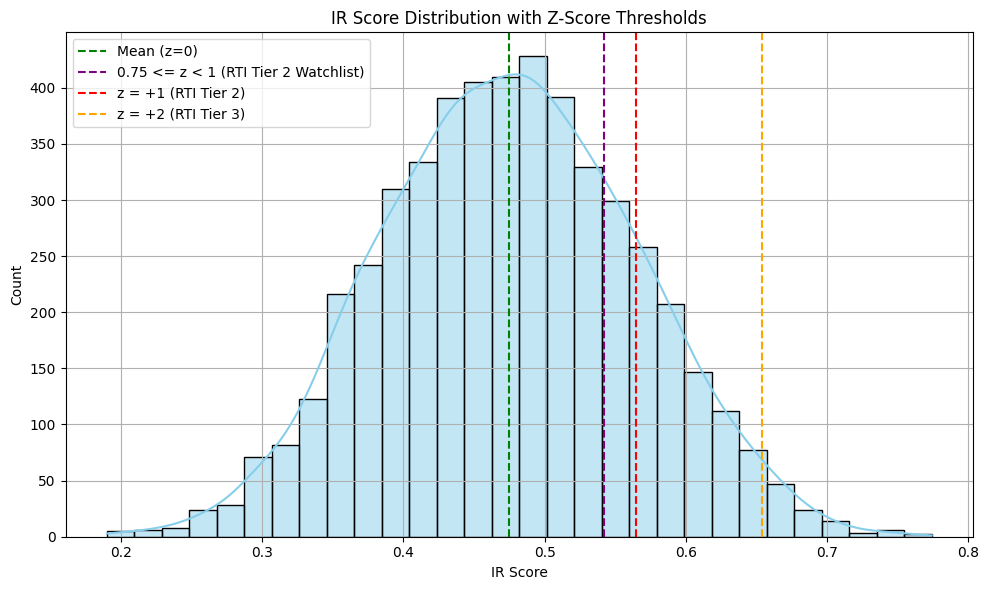

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate z-scores
sample_mean = df['IR_Score'].mean()
sample_std = df['IR_Score'].std()

df['IR_Z_Score'] = (df['IR_Score'] - sample_mean) / sample_std

def assign_rti_category(z):
    if z >= 2:
        return 'RTI Tier 3'
    elif z >= 1:
        return 'RTI Tier 2'
    elif z >= 0.75:
        return 'RTI Tier 2 Watchlist'
    else:
        return 'RTI Tier 1'


df['RTI_Category'] = df['IR_Z_Score'].apply(assign_rti_category)

# Display the distribution of risk categories
print(df['RTI_Category'].value_counts())

# Visualize
plt.figure(figsize=(10, 6))
sns.histplot(df['IR_Score'], bins=30, kde=True, color='skyblue')

# Add z-score-based threshold lines
plt.axvline(sample_mean, color='green', linestyle='--', label='Mean (z=0)')
plt.axvline(sample_mean + (sample_std * 0.75), color = 'purple', linestyle='--', label='0.75 <= z < 1 (RTI Tier 2 Watchlist)')
plt.axvline(sample_mean + sample_std, color='red', linestyle='--', label='z = +1 (RTI Tier 2)')
plt.axvline(sample_mean + (sample_std * 2), color='orange', linestyle='--', label='z = +2 (RTI Tier 3)')

plt.title("IR Score Distribution with Z-Score Thresholds")
plt.xlabel("IR Score")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## IR Score Distribution (Above)
746 students flagged as Tier 2, ~15% of your sample and is statistically consistent with a +1σ cutoff, and operationally manageable in a real school. Most students (Tier 1) are right around the mean as expected. Tier 2 combined with the watchlist is wide enough to catch early warning signs. Tier 3 is tight, ~2%, but those students are likely already in the system or soon will be due to the fact it is easier to identify a Tier 3 student due to the fact that they are easier to identify due to the fact that their behaviors are exhibited more distinctly.

## Splitting Data into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[
    'IR_Score',
    'Student_ID',
    'Academic_Risk',
    'Engagement_Risk',
    'WellBeing_Risk',
    'Contextual_Risk',
    'Total_Score',
    'RTI_Category',
    'IR_Z_Score'
])


# y = target
y = df['RTI_Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(y_train.describe())
print(y_test.describe())

count           4000
unique             4
top       RTI Tier 1
freq            3065
Name: RTI_Category, dtype: object
count           1000
unique             4
top       RTI Tier 1
freq             773
Name: RTI_Category, dtype: object


## Cross-Validation

We included 4 classifying models to evaluate initial performance. Logistic Regression, RandomForest, SVM, and KNN. StratifiedKFold was used to make sure all samples were represented accurately in each fold.  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier(),
]

# Define cross-validation strategy
stratified_k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
for model in models:
    scores = cross_val_score(model, X, y, cv=stratified_k_folds, scoring='accuracy')
    print(f"{model.__class__.__name__}: Accuracy = {scores.mean():.4f}")


LogisticRegression: Accuracy = 0.9172
RandomForestClassifier: Accuracy = 0.8552
SVC: Accuracy = 0.9042
KNeighborsClassifier: Accuracy = 0.8040


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grid for Random Forest (example)
param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [1000]
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    }
}

models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

best_models = {}
for name, model in models.items():
    print(f"\n GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f"Best Random Forest: Accuracy = {grid_search.best_score_:.4f} with parameters: {grid_search.best_params_}")


 GridSearchCV for LogisticRegression...
Best Random Forest: Accuracy = 0.9652 with parameters: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}

 GridSearchCV for RandomForestClassifier...
Best Random Forest: Accuracy = 0.8535 with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 GridSearchCV for SVC...
Best Random Forest: Accuracy = 0.9828 with parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

 GridSearchCV for KNeighborsClassifier...
Best Random Forest: Accuracy = 0.8053 with parameters: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}


# Training Final Model

In [ ]:
final_model = best_models['SVC']
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy: {accuracy:.4f}")


Final Model Accuracy: 0.9880


## Results Visualization

## Confusion Matrix

The final SVM classifier demonstrated reliable performance for categorizing students in different RTI tiers. Most notably, it showed high precision in identifying low-risk (Tier 1) and high-risk (Tier 3) students, with only minor confusion between Tier 2 and the Watchlist — which shows there is a little overlap between these 2 categories. This supports the model’s potential as a reliable early-warning tool for SPED and intervention support teams.



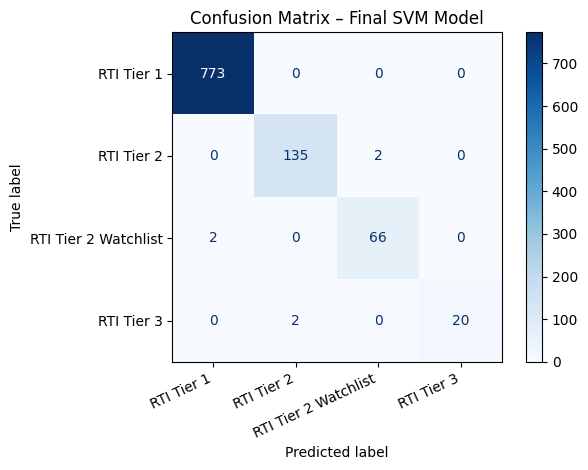

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix – Final SVM Model")

# Rotate x-axis tick labels
plt.xticks(rotation=25, ha='right')

plt.tight_layout()
plt.show()


## Conclusion
Our model to predict Intervention Risk (IR) score was shown to be very accurate through our testing. By cleaning and normalizing our data, and creating a risk calculation formula, we were able to calculate a research based IR score for each student representing a the likelihood for intervention. We split our data into training and testing sets, then performed a cross-validation analysis and hyperparameter tuning to choose between Logistic Regression, Random Forest, SVC and KNearestNeighbors for modeling. The best of our SVC models had the highest accuracy, so it was chosen to train our final model. The final model has 98.8% accuracy at predicting student intervention risk correctly.

## Discussion

This project demonstrates how a machine learning can be used to support early identification of students who may need academic intervention. Our classification strategy, based on z-score thresholds, provides educators with a data-driven tool that generates interpretable actionable insights based on a student's RTI classification. This is especially useful in under-resourced SPED departments, where high student-to-teacher ratios make it difficult to proactively identify every struggling learner.

One of the more valuable aspects of this project is its potential to identify students who are not immediately idetified for intervention, but are in fact struggling quietly. These silent struggling students who may have average or even passing grades but are putting in disproportionate effort to keep up, are kids that often go unrecognized because of high participation in class. This model can help ensure a more equitable distribution of resources so that more students that are struggeling, who might not otherwise be identified, can have access to the resources they are entitled to.

While this model is a proof of concept, it could be adapted for real-world use with minor tuning to reflect local thresholds, additional features (e.g., language status, attendance trends), or real-time updates from student information systems.